In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")


#calculations
import numpy as np
import pandas as pd 
from scipy import stats

#dataset
from pydataset import data
import os

#sklearn stuff 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#graphing
import matplotlib.pyplot as plt
import seaborn as sns

#acquire and prepare data
import acquire 
import prepare
import wrangle

## step 1: Build out the function that I am using to acquire the Telco data set 

In [2]:
def new_telco_data():
    '''
    This function reads the telco data and turns it into a dataframe.
    '''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    url = get_db_url('telco_churn')
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, url)
    
    return df

In [3]:
def get_telco_data():
    '''
      reads telco data, caches it to a local file if there is not one, and returns a df
    '''
    if os.path.isfile('telco.csv'):
        
        # If there is a csv file read the data.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        df = new_telco_data()
        
        # Cache data if there is not a csv file already
        df.to_csv('telco.csv')
        
    return df

In [4]:
# run program to ensure that it runs correctly, no abnormalities found
df = get_telco_data()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


### - now that the data has been acquired, move to prepare the data

# Step 2: prepare the data

In [5]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

- we need to drop the columns that aren't necessary or are redundant. 
- fix total charges, make it a float instead of an object. 
- create dummy variables column to more easily deal with the data
- concatenate the dummy variables df to df so that we can work with the data

In [6]:
def prep_telco_data(df):
    #drop columns that aren't necessary 
    
        columns = ['customer_id', 'payment_type_id', 'internet_service_type_id' , 'contract_type_id']
        df.drop(columns, inplace = True, axis = 1)
    
    #fix total charges
    
        df['total_charges'] = df['total_charges'].str.strip()
        df = df[df.total_charges != '']
        df['total_charges'] = df.total_charges.astype(float)
    
    #get dummy variables
        dummy_df = pd.get_dummies(df[['gender', \
                                    'partner', \
                                    'dependents', \
                                    'phone_service', \
                                    'paperless_billing', \
                                    'churn', \
                                    'multiple_lines', \
                                    'online_security', \
                                    'device_protection', \
                                    'tech_support', \
                                    'streaming_tv', \
                                     'streaming_movies', \
                                     'contract_type', \
                                     'internet_service_type', \
                                     'payment_type']], dummy_na=False, \
                                  drop_first=True)
    
        df = pd.concat([df, dummy_df], axis = 1)
    
        return df

In [7]:
# we will now set the df to be the prepared telco df 
df = prep_telco_data(df)

In [8]:
# check to see that the prepare went smoothly and that dummy df was added correctly

df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,0,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,1,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,1,0,1,0,0,1,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,0,0,0,1,0,0,0,1


In [9]:
df.dtypes

gender                                    object
senior_citizen                             int64
partner                                   object
dependents                                object
tenure                                     int64
phone_service                             object
multiple_lines                            object
online_security                           object
online_backup                             object
device_protection                         object
tech_support                              object
streaming_tv                              object
streaming_movies                          object
paperless_billing                         object
monthly_charges                          float64
total_charges                            float64
churn                                     object
contract_type                             object
internet_service_type                     object
payment_type                              object
gender_Male         

- dtypes are showing as expected

In [10]:
# check for null values
df.isna().sum()

gender                                   0
senior_citizen                           0
partner                                  0
dependents                               0
tenure                                   0
phone_service                            0
multiple_lines                           0
online_security                          0
online_backup                            0
device_protection                        0
tech_support                             0
streaming_tv                             0
streaming_movies                         0
paperless_billing                        0
monthly_charges                          0
total_charges                            0
churn                                    0
contract_type                            0
internet_service_type                    0
payment_type                             0
gender_Male                              0
partner_Yes                              0
dependents_Yes                           0
phone_servi

 - there are no null values reported

### -Prepare stage is complete. 

## Side quest : create a wrangle function that takes care of the acquire and prepare steps in one function

### wrangle function will make it a lot cleaner in the final project, being able to just call one funciton to take care of everything. we can call on the acquire and prepare functions that have already been made in order to make this function

In [11]:
def wrangle_telco():
    df = get_telco_data()
    df = prep_telco_data(df)
    return df

In [12]:
df = wrangle_telco()
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,0,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,1,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,1,0,1,0,0,1,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,0,0,0,1,0,0,0,1


### - side quest complete, wrangle function works as expected

# step 4: divide the df into train_test_split

In [13]:
# this will split the telco data into train, validate, and test models 
  
train_validate, test = train_test_split(df, test_size= .2, 
                                                    random_state= 123, 
                                                    stratify=df.churn)
train, validate = train_test_split(train_validate, test_size= .3, 
                                                            random_state= 123, 
                                                            stratify= train_validate.churn)

In [14]:
train.shape

(3937, 45)

In [15]:
X_train = train.drop(columns=["churn"])
y_train = train.churn

X_validate = validate.drop(columns=["churn"])
y_validate = validate.churn

X_test = test.drop(columns=["churn"])
y_test = test.churn

In [16]:
X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
5919,Female,0,No,No,58,Yes,Yes,Yes,Yes,Yes,...,0,0,0,1,0,0,0,1,0,0
1915,Male,0,No,Yes,71,Yes,Yes,Yes,Yes,No,...,0,0,0,1,0,1,0,1,0,0
5054,Female,0,Yes,Yes,35,Yes,Yes,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,1,0
2355,Male,0,Yes,Yes,1,Yes,No,No internet service,No internet service,No internet service,...,0,1,0,0,0,0,1,0,0,1
6279,Male,1,No,No,20,Yes,No,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1


In [17]:
df

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,0,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,1,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,1,0,1,0,0,1,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,...,0,0,1,0,0,1,0,0,1,0
7040,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,0,0,0,0,0,0,0,0,1
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,...,0,0,1,0,1,0,0,0,0,1


### now that the data has been prepared and split, we can do some exploration



# Explore phase

In [18]:
# first, let's see how many people have churned in the train data set
train.churn.value_counts()

No     2891
Yes    1046
Name: churn, dtype: int64

In [19]:
churn_rate = train.churn_Yes.mean()
print('The rate of churn is' , round(churn_rate,4) *100 , 'percent')

The rate of churn is 26.57 percent


## Takeaway : about 27% of the customers are churning

## let's see if there are any traits that people who are churning share

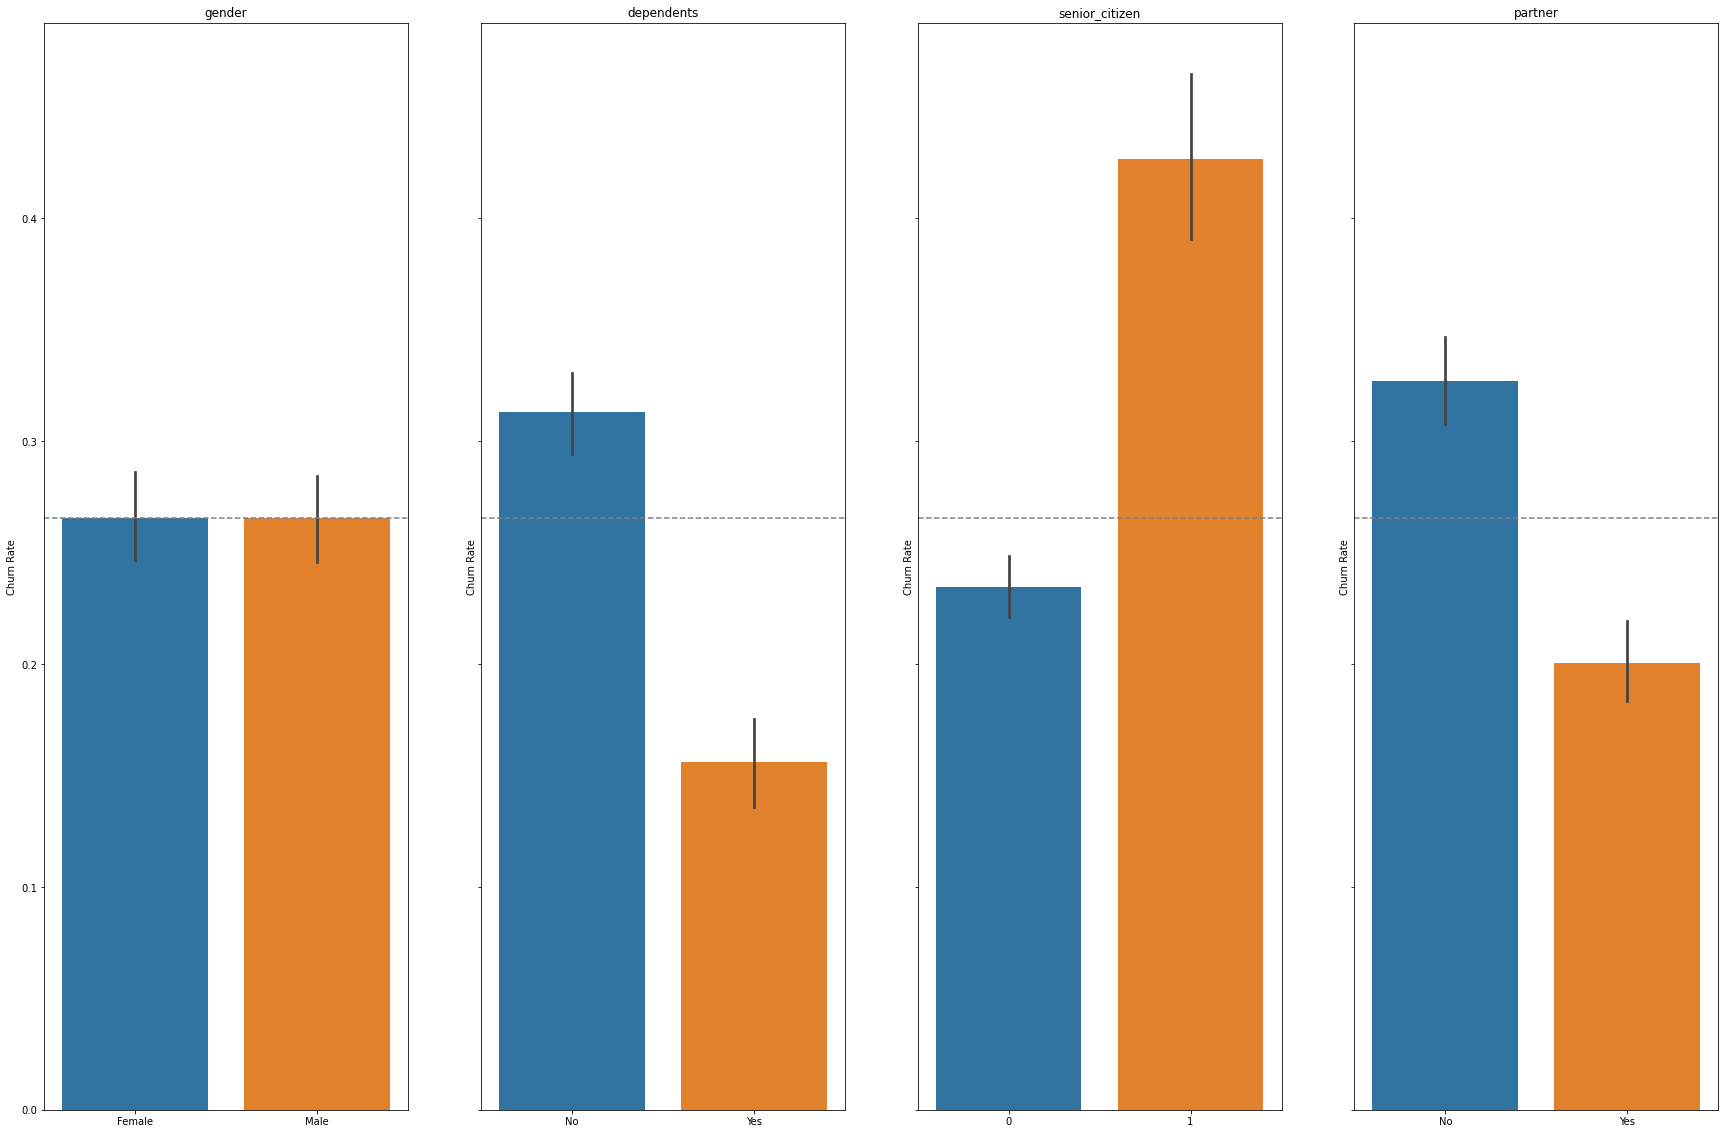

In [36]:
traits = ['gender', 'dependents', 'senior_citizen' , 'partner']
_, ax =plt.subplots(nrows = 1, ncols = 4, figsize = (30, 20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'grey')

# Takeaways:
### - seniors tend to churn more, gender has no real influence on churn, customers with dependents seem to churn less, customers without partners churn more

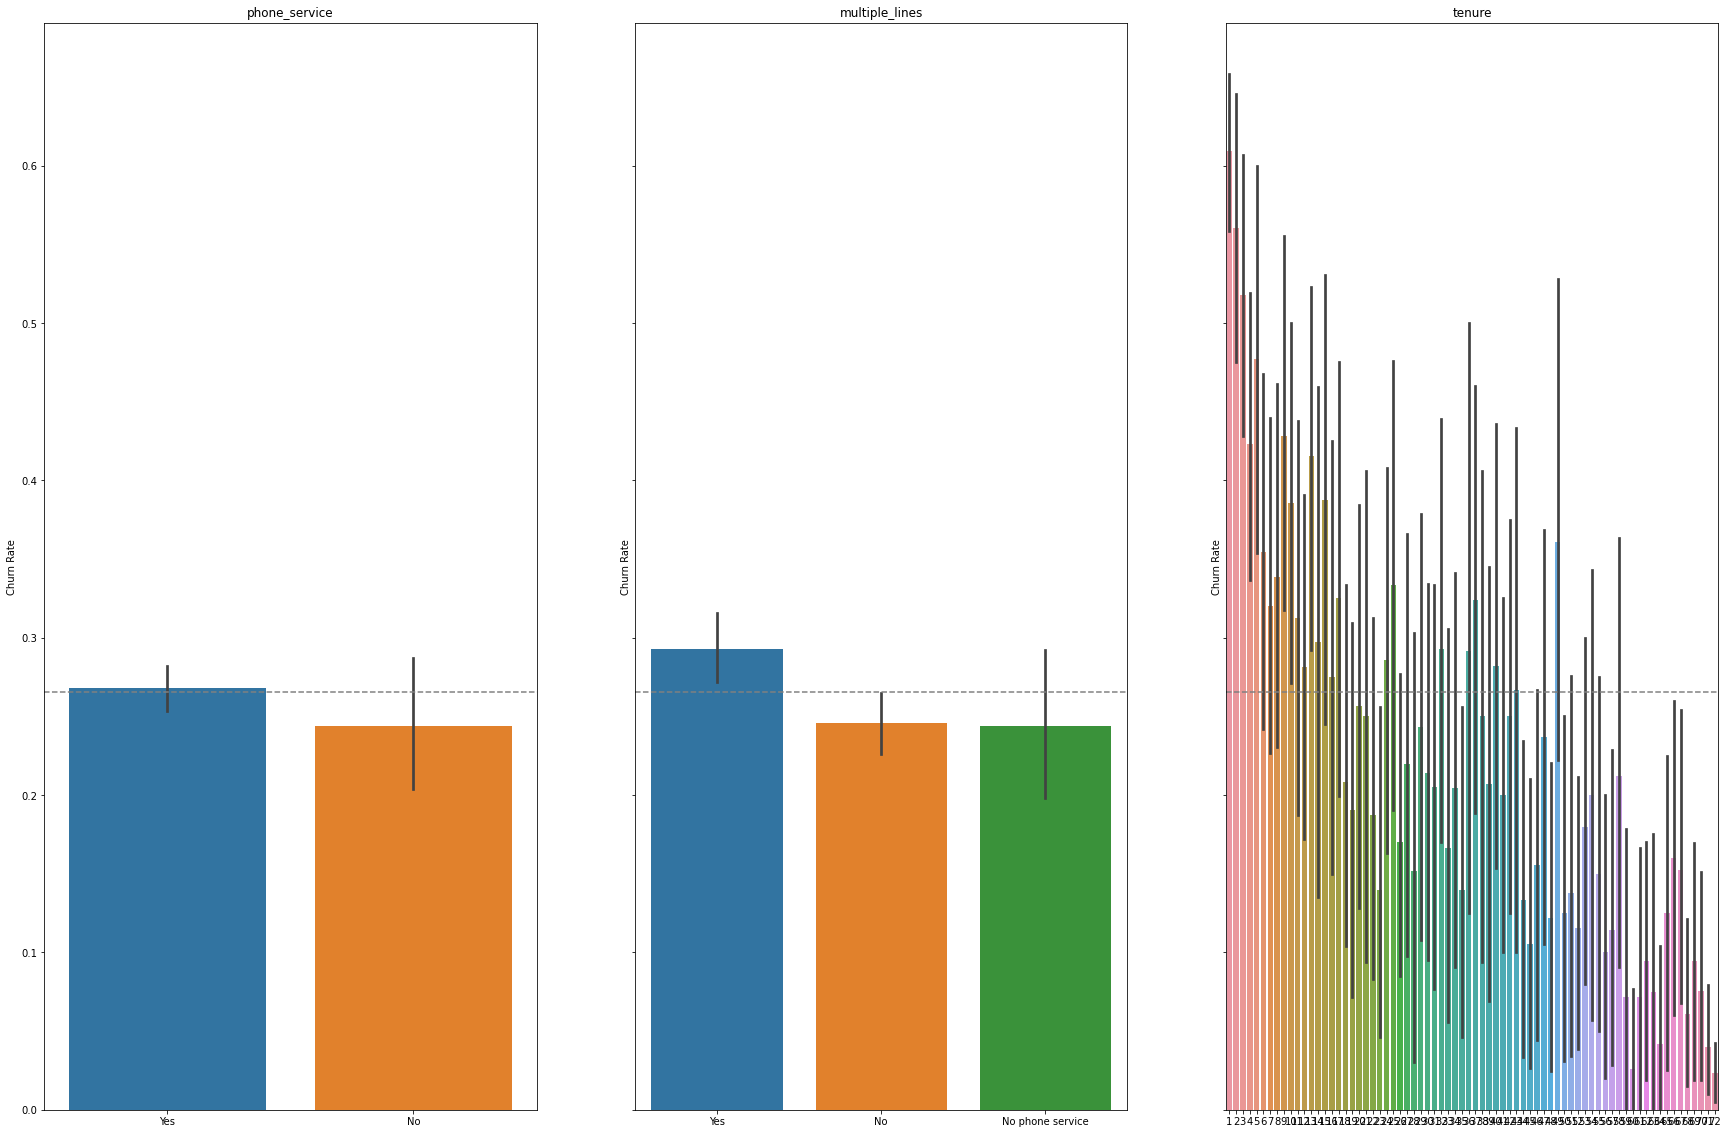

In [38]:
traits = ['phone_service', 'multiple_lines', 'tenure']
_, ax =plt.subplots(nrows = 1, ncols = 3, figsize = (30, 20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'grey')

# Takeaways
- not a huge difference in phone service churn
- multiple lines does not seem to have influence 

### -need to bin tenure to make the data easier to read to try to get a better feel on how it drives churn

In [58]:
def tenure_binned(i):
    if i['tenure'] < 16: 
        return"1 - 15"
    elif i['tenure'] > 15 and i['tenure']< 31:
        return "16 - 30" 
    elif i['tenure'] >30 and i['tenure']<46: 
        return"31 - 45" 
    elif i['tenure'] >45 and i['tenure']< 61: 
        return "46-60" 
    elif i['tenure'] >60:
        return"61+" ;


In [59]:
df['tenure_binned'] = df.apply(lambda x: tenure_binned(x), axis = 1)

In [60]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
gender,Female,Male,Male,Male,Female,Female,Female,Male,Female,Female,...,Male,Male,Female,Female,Female,Female,Male,Male,Male,Male
senior_citizen,0,0,0,1,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
partner,Yes,No,No,Yes,Yes,No,Yes,Yes,No,Yes,...,No,Yes,No,No,No,No,Yes,No,Yes,Yes
dependents,Yes,No,No,No,No,Yes,No,No,No,Yes,...,No,Yes,No,No,No,No,No,No,Yes,Yes
tenure,9,9,4,13,3,9,71,63,7,65,...,1,47,7,1,4,13,22,2,67,63
phone_service,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No
multiple_lines,No,Yes,No,No,No,No,No,Yes,No,Yes,...,No,No,No,No,No,No,Yes,No,No,No phone service
online_security,No,No,No,No,No,No,Yes,Yes,Yes,Yes,...,No internet service,No,No,No,No internet service,Yes,No,No,Yes,Yes
online_backup,Yes,No,No,Yes,No,No,Yes,No,No,Yes,...,No internet service,Yes,Yes,No,No internet service,No,No,Yes,No,Yes
device_protection,No,No,Yes,Yes,No,No,Yes,No,No,Yes,...,No internet service,No,No,No,No internet service,No,No,No,Yes,Yes


TypeError: 'AxesSubplot' object is not subscriptable

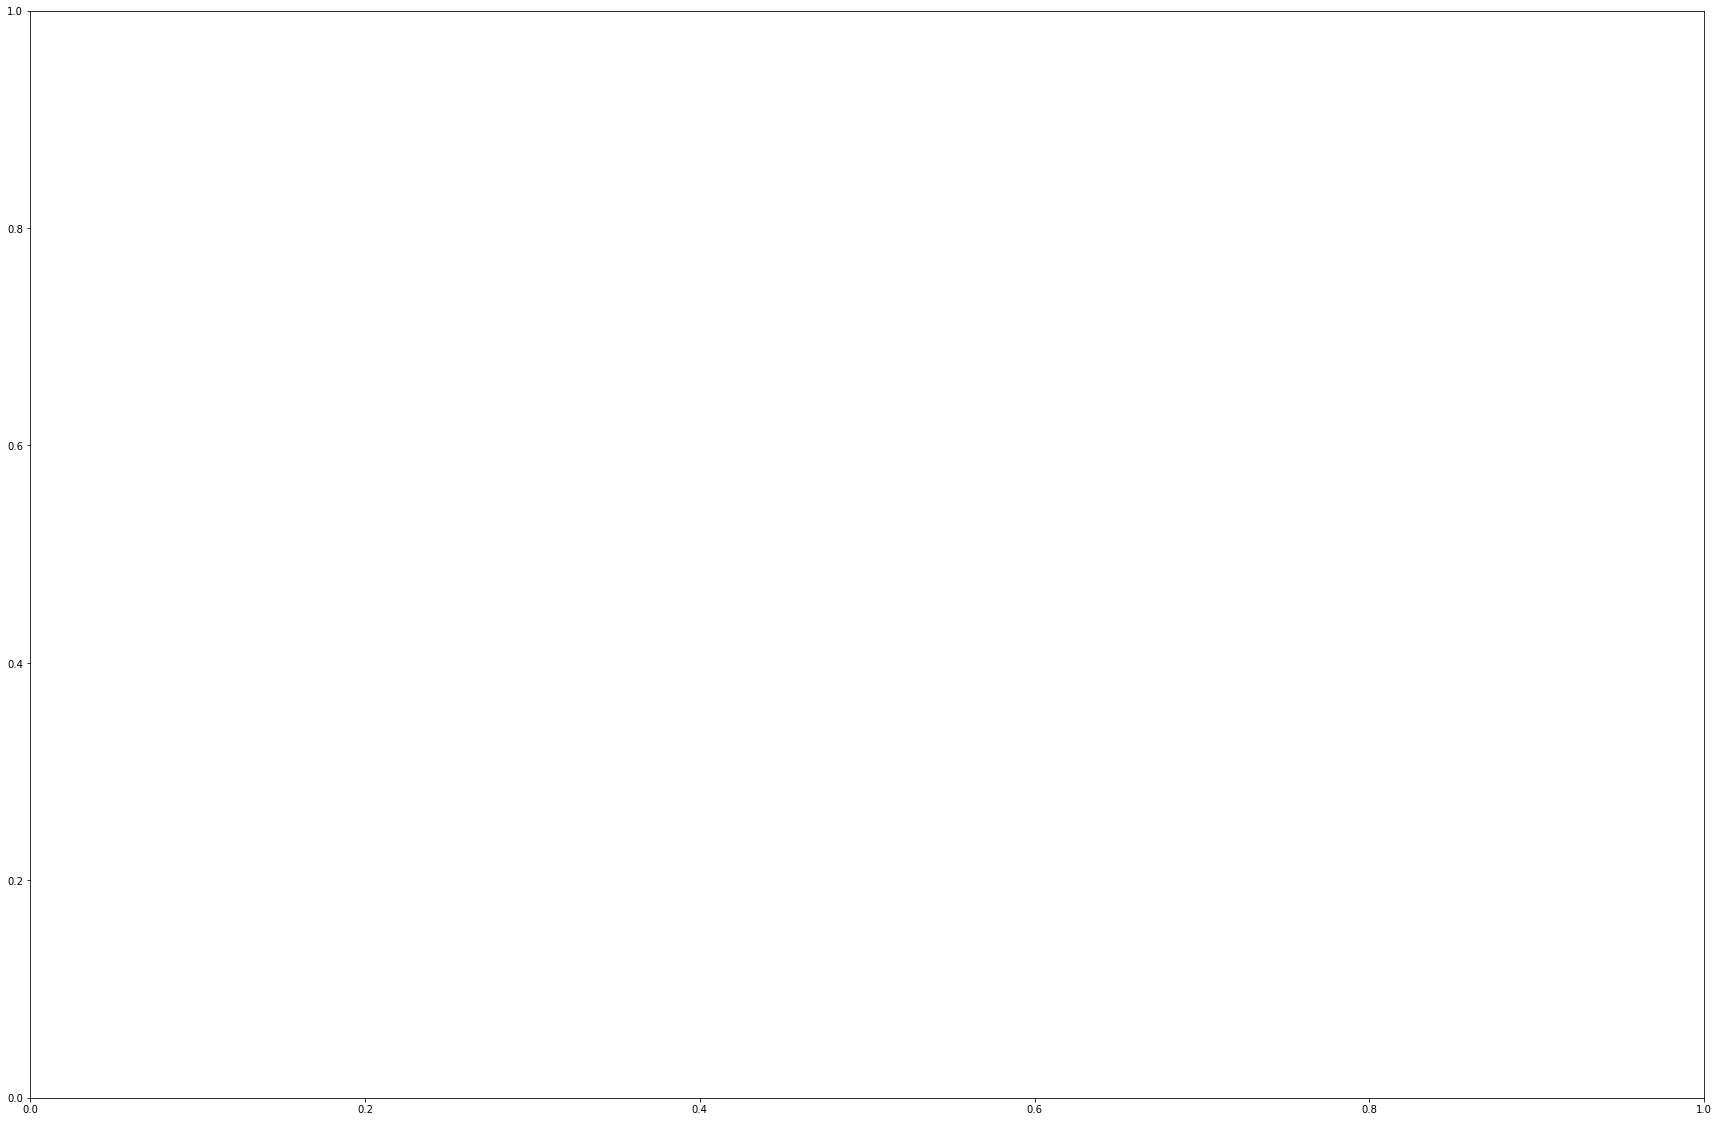

In [61]:
traits = ['tenure_binned']
_, ax =plt.subplots(nrows = 1, ncols = 1, figsize = (30, 20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'grey')

In [62]:
sns.barplot('tenure_binned', 'churn_Yes' , data = train)

ValueError: Could not interpret input 'tenure_binned'

In [63]:
df.tenure_binned.value_counts()

1 - 15     2459
61+        1407
16 - 30    1171
46-60      1038
31 - 45     957
Name: tenure_binned, dtype: int64